In [1]:
#importing the libraries
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\Aiswarya\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


[*********************100%***********************]  1 of 1 completed


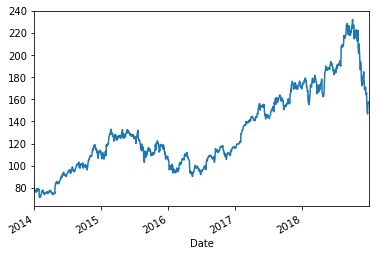

In [2]:
# Install yfinance package.
!pip install yfinance
 
# Import yfinance
import yfinance as yf  
 
# Get the data for the stock Apple by specifying the stock ticker, start date, and end date
data = yf.download('AAPL','2014-01-01','2019-01-01')
 
# Plot the close prices
import matplotlib.pyplot as plt
data.Close.plot()
plt.show()

In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-31,79.167145,80.182854,79.142860,80.145714,72.121513,55771100
2014-01-02,79.382858,79.575714,78.860001,79.018570,71.107201,58671200
2014-01-03,78.980003,79.099998,77.204285,77.282860,69.545288,98116900
2014-01-06,76.778572,78.114288,76.228569,77.704285,69.924515,103152700
2014-01-07,77.760002,77.994286,76.845711,77.148575,69.424438,79302300


In [4]:
#caculating the returns
lrets = np.log(data['Adj Close']/data['Close'].shift(1)).dropna()

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2018-01-12 to 2020-01-10
Data columns (total 6 columns):
Open         502 non-null float64
High         502 non-null float64
Low          502 non-null float64
Close        502 non-null float64
Adj Close    502 non-null float64
Volume       502 non-null int64
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


In [12]:
# ADF test
result = adfuller(lrets)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.6536731175499648
p-value: 0.45512549586755174
Critical Values:
	1%: -3.4356474307506084
	5%: -2.8638793281844253
	10%: -2.5680154897465575


#### As the critical value is higher than ADF statistic we have to do seasonal decomposition to make it stationary


<Figure size 432x288 with 0 Axes>

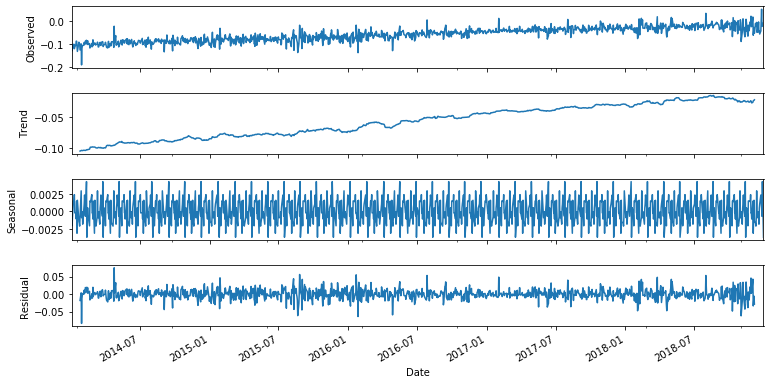

In [14]:
#removing the seasonality and trend to make it stationary
from statsmodels.tsa.seasonal import seasonal_decompose

result=seasonal_decompose(lrets,model='additive',freq=30)
fig=plt.figure()
fig=result.plot()
fig.set_size_inches(12,6)

In [19]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(lrets, nlags=20)
lag_pacf = pacf(lrets, nlags=20, method='ols')


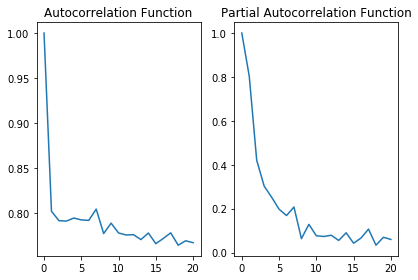

In [20]:
#plot ACF
plt.subplot(121) 
plt.plot(lag_acf)
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [22]:
import warnings
warnings.filterwarnings("ignore")
model=arch_model(lrets, vol='Garch', p=1,o=1,q=1, dist='Normal')
results=model.fit()
print(results.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: -2507.945954034479
Iteration:      2,   Func. Count:     21,   Neg. LLF: -2517.8214971890966
Iteration:      3,   Func. Count:     33,   Neg. LLF: -2519.43522910574
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2519.435231955381
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 3
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   None   R-squared:                      -0.035
Mean Model:             Constant Mean   Adj. R-squared:                 -0.035
Vol Model:                  GJR-GARCH   Log-Likelihood:                2519.44
Distribution:                  Normal   AIC:                          -5028.87
Method:            Maximum Likelihood   BIC:                          -5003.19
                                        No. Observations:                 1256
Date:     

C:\Users\Aiswarya\Anaconda3\lib\site-packages\arch\univariate\base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Text(0.5, 1.0, 'Apple Absolute Returns')

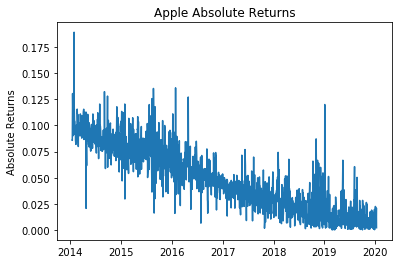

In [22]:
#plotting the absolute returns of the origninal data
plt.plot(lrets.index, np.abs(lrets))
plt.ylabel('Absolute Returns')
plt.title("Apple Absolute Returns")

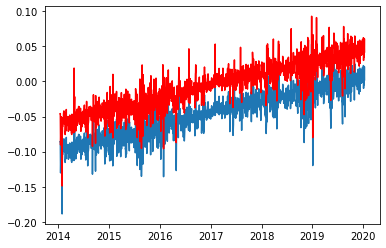

In [23]:
#plotting residuals and the original data
plt.plot(lrets)
plt.plot(results.resid, color='red')

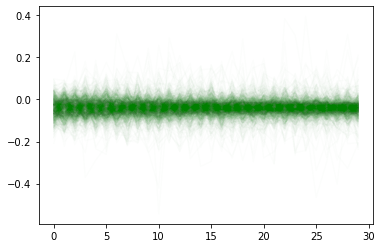

-0.10070709605243869


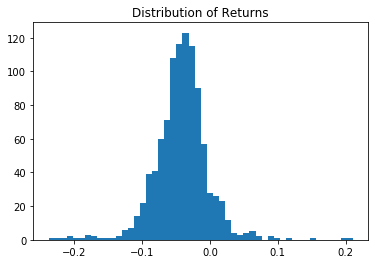

In [24]:
# forcasting for 30 days from the end date of  data
forecasts = results.forecast(horizon=30, method='simulation', simulations=1000)
sims = forecasts.simulations

lines = plt.plot(sims.values[-1,:,:].T, color='green', alpha=0.01)
lines[0].set_label('Simulated paths')
plt.show()

print(np.percentile(sims.values[-1,:,-1].T,5))
plt.hist(sims.values[-1, :,-1],bins=50)
plt.title('Distribution of Returns')
plt.show()